# Extended Mon-Jasnow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import palettable as pl
emr = pl.cartocolors.sequential.Emrld_7_r.get_mpl_colormap()
plt.style.use('Solarize_Light2')

In [2]:
from lattice_utils import basic_lattice, convert_pp_to_pm#, get_flip_energy
from mon_jasnow import ising_hamiltonian#, metropolis_subroutine

In [13]:
@njit
def metropolis_subroutine(lat_pp, T, bc="mj"):
    """
    Subroutine for metropolis algorithm.
    Handles spin flipping for the lattice. 


    Timings:
          100x100:  14.1 ms ± 339 µs
        1000x1000:  1.56 s ± 40.3 ms

    Returns:
        Nothing. Does all lattice manipulation in place.
    
    """

    N = lat_pp.shape[1]
    n = 0
    while n < N ** 2:  # N^2 Flip tries.
        i, j = np.random.randint(
            0, N, size=2
        )  # Generate random indices and shift in the direction that has extra rows.

        if bc == "mj":  # Shift index to not flip boundary edges
            i += 1

        flip_energy_pp = get_flip_energy(i, j, lat_pp, bc=bc)
#         tmp = lat_pp.copy()
#         tmp[i,j] *= -1
#         ediff = ising_hamiltonian(tmp, J=1.0, boundary_cond=bc) - ising_hamiltonian(lat_pp, boundary_cond=bc)
#         print(flip_energy_pp, ediff)
        
        if T == 0.0:
            if flip_energy_pp <= 0.0:
                lat_pp[i, j] *= -1
                # lat_pm[i, j] *= -1
            else:
                pass
        else:
            transition_prob = np.exp(-flip_energy_pp / T)  # W(x|y)
            r = np.random.uniform(0.0, 1.0)

            if transition_prob >= r:
                lat_pp[i, j] *= -1
                # lat_pm[i, j] *= -1
        n += 1
        
        
@njit
def get_flip_energy(i, j, lat, bc="mj"):
    """
    (Local Hamilonian)
    Returns integer of sum of nearest spins times the on site spin.
    Assumes periodic boundary conditions in the second axis and no index error in the first axis.
    
    Used for getting the transition probability in metropolis algorithm
    """

    sp = lat[i, j]
    J = 1.0
    if bc == "mj":  # Boundary conditions for the original Mon Jasnow Algorithm
        n = lat.shape[1]  # Original number of points along each direction


        j_1 = (j + 1) % n  # PBC y-dir
        j_2 = (j - 1) % n  # PBC y-dir

        sum_other = lat[i - 1, j] + lat[i + 1, j] + lat[i, j_1] + lat[i, j_2]

        return (
            sp * J * sum_other
        )  # Difference in energy when flipping. Minussign in H accounted for

    elif bc == "torus":  # Boundary condition for torus

        nx, ny = lat.shape
        sum_other = (
            lat[(i - 1) % nx, j]
            + lat[(i + 1) % nx, j]
            + lat[i, (j + 1) % ny]
            + lat[i, (j - 1) % ny]
        )
        return sp * J * sum_other *2
    
    elif bc == 'klein':
        tmp = lat.copy()
        tmp[i,j] *= -1
        
        e_flip = ising_hamiltonian(tmp, boundary_cond='klein')
        e_noflip =ising_hamiltonian(lat, boundary_cond='klein')
        
        return e_flip - e_noflip

In [4]:
Tc = 2 / (np.log(1+np.sqrt(2)))

In [8]:
N = 30
l = basic_lattice(N)
init = l.copy()

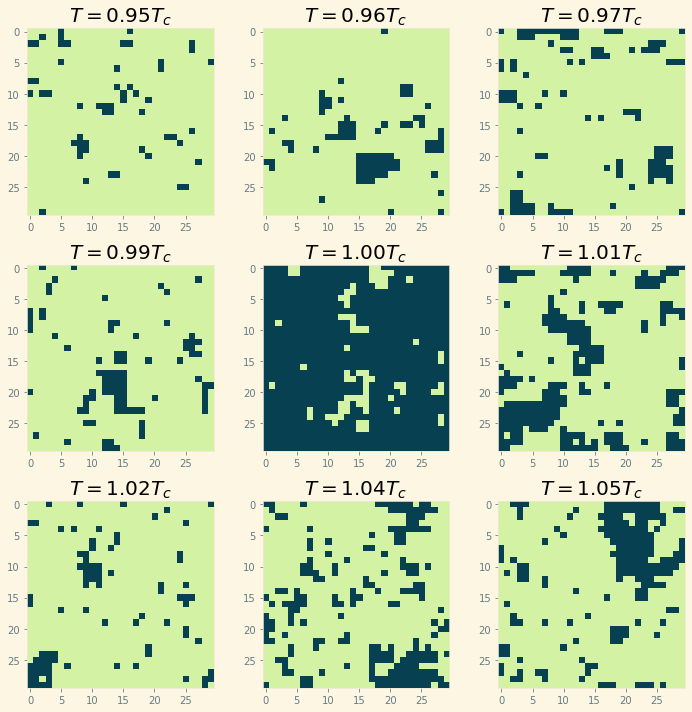

In [63]:
# Plot Torus states near tc

t_arr = np.linspace(0.95,1.05, 9)

fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(10,10))

for i,ax in enumerate(axs.flat):
    
    l = basic_lattice(N)
    for _ in range(1000):
        metropolis_subroutine(l, t_arr[i] * Tc, bc='torus')
    
    
    ax.imshow(l, cmap=emr)
    ax.set_title(f"$T = ${t_arr[i]:.2f}$T_c$", size=20)
    ax.grid()
#     plt.show()
fig.tight_layout()

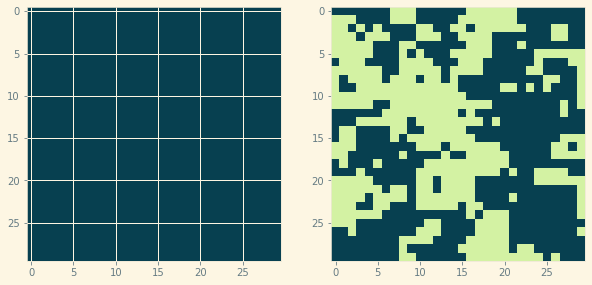

In [11]:
for i in range(1000):
    metropolis_subroutine(l, 2.6, bc='torus')
plt.figure(figsize= (10, 10))
plt.subplot(121)
plt.imshow(init, cmap=emr)
plt.subplot(122)
plt.imshow(l, cmap = emr)
plt.grid()

In [12]:
# for i in range(100):
#     metropolis_subroutine(l,T=0.01, bc = 'torus')
%time Hk = ising_hamiltonian(l, boundary_cond='klein')
%time Ht = ising_hamiltonian(l, boundary_cond='torus')
print(Hk, Ht)
print(Hk-Ht)



Wall time: 0 ns
Wall time: 0 ns
-836.0 -864.0
28.0


## Check klein states

In [22]:
k = basic_lattice(30)
init_k =k.copy()

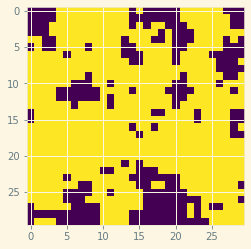

In [62]:
metropolis_subroutine(k, 2.4,bc='klein')
plt.imshow(k)

0
1
2
3
4
5
6
7
8


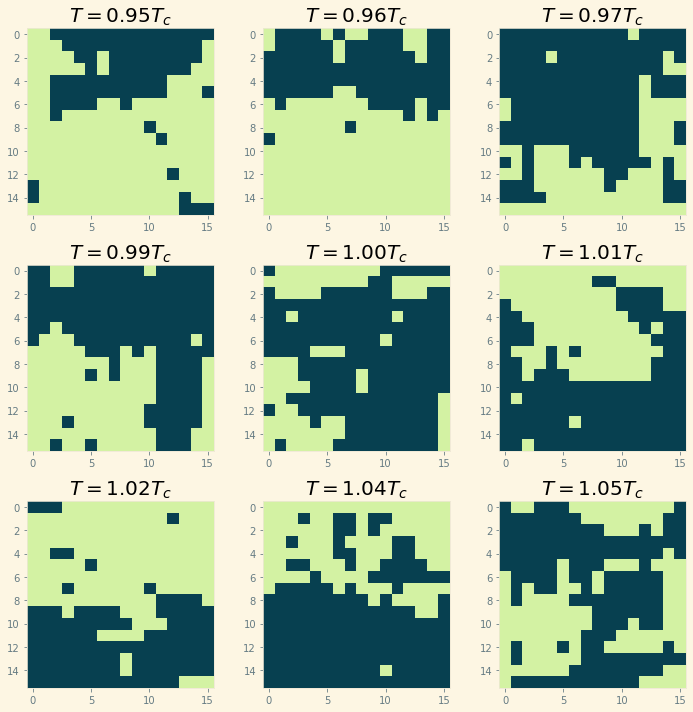

In [65]:
# Plot klein states near tc

t_arr = np.linspace(0.95,1.05, 9)
N=16
fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(10,10))

for i,ax in enumerate(axs.flat):
    print(i)
    l = basic_lattice(N)
    for _ in range(1000):
        metropolis_subroutine(l, t_arr[i] * Tc, bc='klein')
    ax.imshow(l, cmap=emr)
    ax.set_title(f"$T = ${t_arr[i]:.2f}$T_c$", size=20)
    ax.grid()
#     plt.show()
fig.tight_layout()

# Energy difference in torus states

In [374]:
N = 100
l = basic_lattice(N)
init = l.copy()

-408.0 -404.0 -4.0


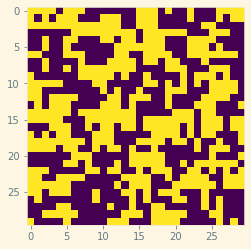

In [347]:
metropolis_subroutine(l, 5, bc= 'torus')
hk = ising_hamiltonian(l, boundary_cond='klein')
ht = ising_hamiltonian(l, boundary_cond='torus')
print(hk, ht, (hk -ht))
plt.imshow(l)
plt.grid()

In [364]:
@njit
def ediff(l):
    return np.sum(l[-1,:]*(l[0,::-1] + l[0,:]))

In [375]:
%timeit ediff(l)

899 ns ± 62.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [376]:
%%timeit
hk = ising_hamiltonian(l, boundary_cond='klein')
ht = ising_hamiltonian(l, boundary_cond='torus')
diff = hk - ht

205 µs ± 8.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [215]:
kk =np.arange(9).reshape((3,3))

In [381]:
%%time
for _ in range(10000):
    rl = basic_lattice(30, aligned=False)# Random matrices
    e1 = ediff(rl)
    hk = ising_hamiltonian(rl, boundary_cond='klein')
    ht = ising_hamiltonian(rl, boundary_cond='torus')
    diff = hk - ht
    if e1 != diff:
        print("Yuck")

Wall time: 370 ms
